<a href="https://colab.research.google.com/github/melinadwisafitri/skripsi_price_predict/blob/main/cabai_merah_besar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Library

In [3]:
import urllib.request
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import math

from keras.utils.vis_utils import plot_model
from tensorflow.data import Dataset
from tensorflow.keras.losses import Huber
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout
from tensorflow.keras.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, RootMeanSquaredError

## time step generator

In [4]:
def time_step_generator(data, time_size, batch_size, shuffle_data):
  dataset = Dataset.from_tensor_slices(data)
  dataset = dataset.window(time_size+1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda x: x.batch(time_size+1))
  dataset = dataset.shuffle(shuffle_data)
  dataset = dataset.map(lambda x: (x[:-1], x[-1]))
  return dataset.batch(batch_size).prefetch(1)

def forecast_predict(model, data, time_size, batch_size):
  generate_data = Dataset.from_tensor_slices(data)
  add_window_step = generate_data.window(time_size, shift=1, drop_remainder=True)
  flatten_window = add_window_step.flat_map(lambda window: window.batch(time_size))
  batch_window = flatten_window.batch(batch_size).prefetch(1)
  model_predict = model.predict(batch_window)
  return model_predict

## Load data

In [5]:
url ='https://github.com/melinadwisafitri/skripsi_price_predict/blob/main/data_pangan/data_fixs/data_new.csv?raw=true'
urllib.request.urlretrieve(url, 'data_pangan.csv')

('data_pangan.csv', <http.client.HTTPMessage at 0x7f59b69fa880>)

In [6]:
dataset = pd.read_csv('data_pangan.csv')
dataset.head()

,date,beras,beras_kualitas_bawah_i,beras_kualitas_bawah_ii,beras_kualitas_medium_i,beras_kualitas_medium_ii,beras_kualitas_super_i,beras_kualitas_super_ii,daging_ayam_ras_segar,daging_sapi_kualitas_1,...,cabai_rawit,cabai_rawit_hijau,cabai_rawit_merah,minyak_goreng,minyak_goreng_curah,minyak_goreng_kemasan_bermerk_1,minyak_goreng_kemasan_bermerk_2,gula_pasir,gula_pasir_kualitas_premium,gula_pasir_lokal
0,2017-01-08,11200,10150,9650,11250,11150,12750,12250,34100,118400,...,41050,34800,47550,13950,12250,15050,14350,14900,16800,13250
1,2017-01-11,11400,10350,9900,11500,11300,12900,12350,30350,117000,...,30000,30000,30450,13900,12250,14950,14300,14500,16550,12900
2,2017-01-12,10700,9650,8500,11200,10950,12250,11850,29350,115800,...,33300,31500,35050,14000,12150,15400,14400,14800,16650,12950
3,2017-02-08,11200,10150,9650,11250,11150,12750,12250,34150,118400,...,40600,34600,46650,13950,12250,15050,14350,14900,16800,13250
4,2017-02-10,11400,10250,9850,11400,11250,12850,12350,30200,118400,...,31850,32550,31550,14000,12350,15000,14350,14700,16750,12950


In [7]:
dataset['date'] = pd.to_datetime(dataset['date'])

In [8]:
dataset = dataset.set_index('date')
dataset = dataset.sort_index()
train = dataset.cabai_merah_besar.values
date = dataset.index

## Train test val split

In [9]:
x_train, x_test, y_train, y_test = train_test_split(train, date, test_size=0.2, random_state=False, shuffle=False)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.125, random_state=False, shuffle=False) # 0.125 x 0.48 = 0.1

print(f'{len(x_train)}\n{len(x_test)}')

818
234


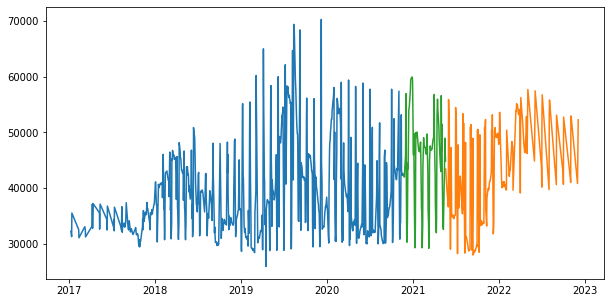

In [10]:
plt.figure(figsize=(10, 5))
plt.plot(y_train, x_train)
plt.plot(y_test, x_test)
plt.plot(y_val, x_val)
plt.show()

## data generate

In [11]:
scal_range= MinMaxScaler(feature_range=(0,1))
train_scal = scal_range.fit_transform(x_train.reshape(-1, 1))
test_scal = scal_range.fit_transform(x_test.reshape(-1, 1))
val_scal = scal_range.fit_transform(x_val.reshape(-1, 1))
train_step = time_step_generator(train_scal, time_size=600, shuffle_data=100, batch_size=5)
val_step = time_step_generator(val_scal, time_size=80, shuffle_data=100, batch_size=20)
test_step = time_step_generator(test_scal, time_size=150, shuffle_data=1000, batch_size=5)

train_step1 = time_step_generator(train_scal, time_size=100, shuffle_data=100, batch_size=1)
val_step1 = time_step_generator(val_scal, time_size=1, shuffle_data=10, batch_size=1)
test_step1 = time_step_generator(test_scal, time_size=10, shuffle_data=100, batch_size=1)

train_step2 = time_step_generator(train_scal, time_size=400, shuffle_data=1000, batch_size=5)
val_step2 = time_step_generator(val_scal, time_size=50, shuffle_data=100, batch_size=2)
test_step2 = time_step_generator(test_scal, time_size=100, shuffle_data=1000, batch_size=5)

In [12]:
forecast = np.append(x_train, x_test)
forecast_date = np.append(y_train, y_test)
win_size= 400
win_size1 = 60
win_size2=150
test_cabaimerahbesar_ = scal_range.fit_transform(forecast.reshape(-1, 1))

## model 

### SGD

In [ ]:
model= Sequential([
    Conv1D(16, kernel_size=2, activation='relu',padding='causal', strides=2, input_shape=[None, 1]),
    LSTM(24, return_sequences=True),
    LSTM(20),
    Dense(64, activation='relu'),
    Dense(1)
])

model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9), loss='mse', metrics=['mae', 'mape'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 16)          48        
                                                                 
 lstm (LSTM)                 (None, None, 24)          3936      
                                                                 
 lstm_1 (LSTM)               (None, 20)                3600      
                                                                 
 dense (Dense)               (None, 64)                1344      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 8,993
Trainable params: 8,993
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# plot_model(model, to_file='model1_plot.png', show_shapes=True, show_layer_names=True)

#### type1

In [ ]:
history = model.fit(train_step, epochs=30, validation_data=val_step)

Epoch 1/30
44/44 [==============================] - 18s 80ms/step - loss: 0.1197 - mae: 0.2891 - mape: 89.3341 - val_loss: 0.2907 - val_mae: 0.4861 - val_mape: 85.3307
Epoch 2/30
44/44 [==============================] - 1s 22ms/step - loss: 0.0950 - mae: 0.2430 - mape: 67.5605 - val_loss: 0.2499 - val_mae: 0.4425 - val_mape: 73.6134
Epoch 3/30
44/44 [==============================] - 1s 20ms/step - loss: 0.0772 - mae: 0.2051 - mape: 51.0292 - val_loss: 0.2175 - val_mae: 0.4082 - val_mape: 67.0360
Epoch 4/30
44/44 [==============================] - 1s 20ms/step - loss: 0.0645 - mae: 0.1819 - mape: 45.2889 - val_loss: 0.1939 - val_mae: 0.3843 - val_mape: 64.4817
Epoch 5/30
44/44 [==============================] - 1s 20ms/step - loss: 0.0559 - mae: 0.1704 - mape: 46.1514 - val_loss: 0.1751 - val_mae: 0.3651 - val_mape: 62.9791
Epoch 6/30
44/44 [==============================] - 1s 20ms/step - loss: 0.0498 - mae: 0.1645 - mape: 49.0784 - val_loss: 0.1607 - val_mae: 0.3502 - val_mape: 62.23

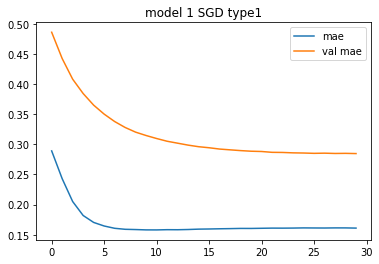

In [ ]:
mae = history.history['mae']
val_mae = history.history['val_mae']
epoch = range(len(mae))

plt.title('model 1 SGD type1')
plt.plot(epoch, mae, label='mae')
plt.plot(epoch, val_mae, label='val mae')
plt.legend()
plt.show()

131/131 [==============================] - 2s 8ms/step
7001.525 16.880741 8357.652780535933


,date,actual,prediction
0,2021-05-20,43400,39818.917969
1,2021-05-21,42450,39819.343750
2,2021-05-24,40150,39830.519531
3,2021-05-25,39600,39832.421875
4,2021-05-27,38600,39834.679688
...,...,...,...
229,2022-11-02,41000,40195.406250
230,2022-11-03,52950,40209.445312
231,2022-11-04,52850,40183.492188
232,2022-12-01,40800,40191.105469


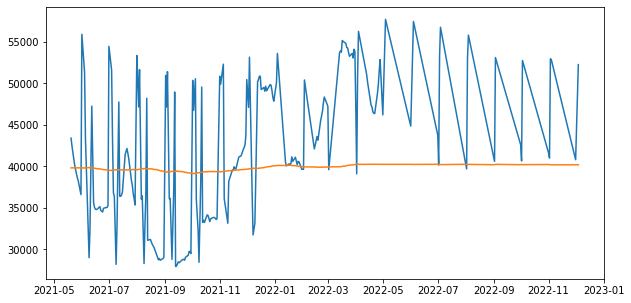

In [ ]:
prediction = forecast_predict(model, test_cabaimerahbesar_, time_size=win_size, batch_size=5)

data_result = prediction[(len(x_train))-win_size:-1, -1 ]
data_result = scal_range.inverse_transform(data_result.reshape(-1, 1))
data_result = data_result.reshape(-1)
mae= tf.keras.metrics.mean_absolute_error(x_test, data_result)
mape = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result)
mse = tf.keras.metrics.mean_squared_error(x_test, data_result)

rmse =math.sqrt(mse.numpy())
print(mae.numpy(), mape.numpy(), rmse)

data_new_cabaimerahbesar = pd.DataFrame()
data_new_cabaimerahbesar['date'] = y_test
data_new_cabaimerahbesar['actual'] = x_test
data_new_cabaimerahbesar['prediction'] = data_result
data_new_cabaimerahbesar.to_csv('cabaimerahbesar_model1_sgd_type1.csv')

plt.figure(figsize=(10, 5))
plt.plot(data_new_cabaimerahbesar.date, data_new_cabaimerahbesar.actual)
plt.plot(data_new_cabaimerahbesar.date, data_new_cabaimerahbesar.prediction)
data_new_cabaimerahbesar

#### type2

In [ ]:
history_t1 = model.fit(train_step1, epochs=30, validation_data=val_step)

Epoch 1/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0336 - mae: 0.1459 - mape: 449341.1562 - val_loss: 0.0950 - val_mae: 0.2761 - val_mape: 63.4272
Epoch 2/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0335 - mae: 0.1464 - mape: 390175.9688 - val_loss: 0.0970 - val_mae: 0.2789 - val_mape: 63.3532
Epoch 3/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0336 - mae: 0.1459 - mape: 400237.0625 - val_loss: 0.0950 - val_mae: 0.2761 - val_mape: 63.4541
Epoch 4/30
718/718 [==============================] - 6s 9ms/step - loss: 0.0335 - mae: 0.1458 - mape: 389356.4688 - val_loss: 0.0926 - val_mae: 0.2727 - val_mape: 63.5764
Epoch 5/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0335 - mae: 0.1463 - mape: 432574.8750 - val_loss: 0.0972 - val_mae: 0.2791 - val_mape: 63.3670
Epoch 6/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0334 - mae: 0.1461 - mape: 429962.3750 - val_loss: 0.0976 - val_

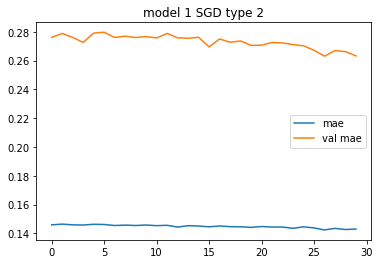

In [ ]:
mae_t1 = history_t1.history['mae']
val_mae_t1 = history_t1.history['val_mae']
epoch_t1 = range(len(mae_t1))

plt.title('model 1 SGD type 2')
plt.plot(epoch_t1, mae_t1, label='mae')
plt.plot(epoch_t1, val_mae_t1, label='val mae')
plt.legend()
plt.show()

199/199 [==============================] - 1s 4ms/step
6740.9214 16.523026 7945.40596823095


,date,actual,prediction
0,2021-05-20,43400,39818.917969
1,2021-05-21,42450,39819.343750
2,2021-05-24,40150,39830.519531
3,2021-05-25,39600,39832.421875
4,2021-05-27,38600,39834.679688
...,...,...,...
229,2022-11-02,41000,40195.406250
230,2022-11-03,52950,40209.445312
231,2022-11-04,52850,40183.492188
232,2022-12-01,40800,40191.105469


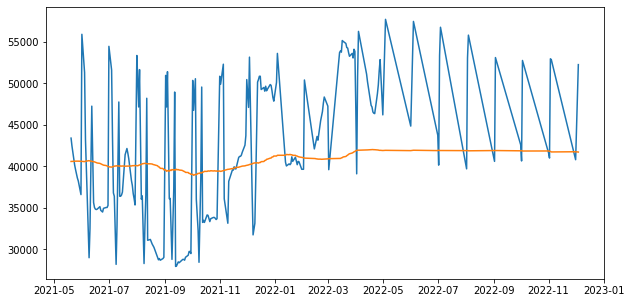

In [ ]:
win_size1 = 60
test_cabaimerahbesar_1 = scal_range.fit_transform(forecast.reshape(-1, 1))
prediction_1 = forecast_predict(model, test_cabaimerahbesar_1, time_size=win_size1, batch_size=5)

data_result_1 = prediction_1[(len(x_train))-win_size1:-1, -1 ]
data_result_1 = scal_range.inverse_transform(data_result_1.reshape(-1, 1))
data_result_1 = data_result_1.reshape(-1)
mae_1= tf.keras.metrics.mean_absolute_error(x_test, data_result_1)
mape_1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result_1)
mse_1 = tf.keras.metrics.mean_squared_error(x_test, data_result_1)
rmse_1 =math.sqrt(mse_1.numpy())
print(mae_1.numpy(), mape_1.numpy(), rmse_1)

data_new_cabaimerahbesar_1 = pd.DataFrame()
data_new_cabaimerahbesar_1['actual'] = x_test
data_new_cabaimerahbesar_1['prediction'] = data_result_1
data_new_cabaimerahbesar_1.to_csv('cabaimerahbesar_model1_sgd_type2.csv')

plt.figure(figsize=(10, 5))
plt.plot(y_test, data_new_cabaimerahbesar_1.actual)
plt.plot(y_test, data_new_cabaimerahbesar_1.prediction)
data_new_cabaimerahbesar

#### type3

In [ ]:
history_t2 = model.fit(train_step2, epochs=30, validation_data=val_step)

Epoch 1/30
84/84 [==============================] - 2s 17ms/step - loss: 0.0417 - mae: 0.1652 - mape: 759893.0625 - val_loss: 0.0848 - val_mae: 0.2603 - val_mape: 64.2529
Epoch 2/30
84/84 [==============================] - 1s 16ms/step - loss: 0.0414 - mae: 0.1654 - mape: 760421.3125 - val_loss: 0.0825 - val_mae: 0.2563 - val_mape: 64.3866
Epoch 3/30
84/84 [==============================] - 1s 15ms/step - loss: 0.0413 - mae: 0.1659 - mape: 784815.5625 - val_loss: 0.0811 - val_mae: 0.2540 - val_mape: 64.4705
Epoch 4/30
84/84 [==============================] - 1s 15ms/step - loss: 0.0413 - mae: 0.1660 - mape: 787087.7500 - val_loss: 0.0808 - val_mae: 0.2534 - val_mape: 64.4926
Epoch 5/30
84/84 [==============================] - 1s 15ms/step - loss: 0.0412 - mae: 0.1661 - mape: 788161.6875 - val_loss: 0.0800 - val_mae: 0.2520 - val_mape: 64.5390
Epoch 6/30
84/84 [==============================] - 1s 15ms/step - loss: 0.0412 - mae: 0.1662 - mape: 784739.8750 - val_loss: 0.0796 - val_mae: 0

In [ ]:
mae_t2 = history_t2.history['mae']
val_mae_t2 = history_t2.history['val_mae']
epoch_t2 = range(len(mae_t2))

plt.title('cabaimerahbesar kualitas rendah 1 model 1 SGD type 3')
plt.plot(epoch_t2, mae_t2, label='mae')
plt.plot(epoch_t2, val_mae_t2, label='val mae')
plt.legend()
plt.show()

In [ ]:
win_size2 = 150
prediction_2 = forecast_predict(model, test_cabaimerahbesar_, time_size=win_size2, batch_size=5)

data_result_2 = prediction_2[(len(x_train))-win_size2:-1, -1 ]
data_result_2 = scal_range.inverse_transform(data_result_2.reshape(-1, 1))
data_result_2 = data_result_2.reshape(-1)
mae_2= tf.keras.metrics.mean_absolute_error(x_test, data_result_2)
mape_2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result_2)
mse_2 = tf.keras.metrics.mean_squared_error(x_test, data_result_2)

rmse_2 =math.sqrt(mse_2.numpy())
print(mae_2.numpy(), mape_2.numpy(), rmse_2)

data_new_cabaimerahbesar_2 = pd.DataFrame()
# data_new_cabaimerahbesar1['date'] = date_test
data_new_cabaimerahbesar_2['actual'] = x_test
data_new_cabaimerahbesar_2['prediction'] = data_result_2
data_new_cabaimerahbesar_2.to_csv('cabaimerahbesar_model1_sgd_type3')

plt.plot(y_test, data_new_cabaimerahbesar_2.actual)
plt.plot(y_test, data_new_cabaimerahbesar_2.prediction)
data_new_cabaimerahbesar_2

### Adam

In [ ]:
model_a= Sequential([
    Conv1D(16, kernel_size=2, activation='relu',padding='causal', strides=2, input_shape=[None, 1]),
        LSTM(24, return_sequences=True),
        LSTM(20),
        Dense(64, activation='relu'),
        Dense(1)
])

model_a.compile(loss= 'mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), metrics=['mae', 'mape'])
model_a.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, None, 16)          48        
                                                                 
 lstm_2 (LSTM)               (None, None, 24)          3936      
                                                                 
 lstm_3 (LSTM)               (None, 20)                3600      
                                                                 
 dense_2 (Dense)             (None, 64)                1344      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 8,993
Trainable params: 8,993
Non-trainable params: 0
_________________________________________________________________


#### Type 1

In [ ]:
history_a = model_a.fit(train_step, epochs=30, validation_data=val_step)

Epoch 1/30
44/44 [==============================] - 4s 39ms/step - loss: 0.1229 - mae: 0.2925 - mape: 90.2020 - val_loss: 0.2829 - val_mae: 0.4778 - val_mape: 83.0181
Epoch 2/30
44/44 [==============================] - 1s 20ms/step - loss: 0.0871 - mae: 0.2277 - mape: 61.4300 - val_loss: 0.1864 - val_mae: 0.3764 - val_mape: 63.8456
Epoch 3/30
44/44 [==============================] - 1s 20ms/step - loss: 0.0494 - mae: 0.1602 - mape: 48.2180 - val_loss: 0.0832 - val_mae: 0.2572 - val_mape: 64.6337
Epoch 4/30
44/44 [==============================] - 1s 20ms/step - loss: 0.0336 - mae: 0.1550 - mape: 71.2648 - val_loss: 0.0672 - val_mae: 0.2236 - val_mape: 66.1040
Epoch 5/30
44/44 [==============================] - 1s 20ms/step - loss: 0.0334 - mae: 0.1555 - mape: 71.0987 - val_loss: 0.0667 - val_mae: 0.2224 - val_mape: 66.2532
Epoch 6/30
44/44 [==============================] - 1s 20ms/step - loss: 0.0331 - mae: 0.1560 - mape: 73.2762 - val_loss: 0.0682 - val_mae: 0.2257 - val_mape: 65.973

In [ ]:
mae_a = history_a.history['mae']
val_mae_a = history_a.history['val_mae']
epoch_a = range(len(mae_a))

plt.title('cabaimerahbesar kualitas rendah 1 model 1 Adam type 1')
plt.plot(epoch_a, mae_a, label='mae')
plt.plot(epoch_a, val_mae_a, label='val mae')
plt.legend()
plt.show()

In [ ]:
prediction_a = forecast_predict(model_a, test_cabaimerahbesar_, time_size=win_size, batch_size=5)

data_result_a = prediction_a[(len(x_train))-win_size:-1, -1 ]
data_result_a = scal_range.inverse_transform(data_result_a.reshape(-1, 1))
data_result_a = data_result_a.reshape(-1)
mae_a= tf.keras.metrics.mean_absolute_error(x_test, data_result_a)
mape_a = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result_a)
mse_a = tf.keras.metrics.mean_squared_error(x_test, data_result_a)

rmse_a =math.sqrt(mse_a.numpy())
print(mae_a.numpy(), mape_a.numpy(), rmse_a)

data_new_cabaimerahbesar_a = pd.DataFrame()
# data_new_cabaimerahbesar1['date'] = date_test
data_new_cabaimerahbesar_a['actual'] = x_test
data_new_cabaimerahbesar_a['prediction'] = data_result_a
data_new_cabaimerahbesar_a.to_csv('cabaimerahbesar_model1_adam_type1.csv')

plt.figure(figsize=(10,5))
plt.plot(y_test, data_new_cabaimerahbesar_a.actual)
plt.plot(y_test, data_new_cabaimerahbesar_a.prediction)
data_new_cabaimerahbesar_a

#### Type 2

In [ ]:
history_a1 = model_a.fit(train_step1, epochs=30, validation_data=val_step)

Epoch 1/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0287 - mae: 0.1324 - mape: 319739.2812 - val_loss: 0.0733 - val_mae: 0.2357 - val_mape: 65.8507
Epoch 2/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0284 - mae: 0.1311 - mape: 314686.7812 - val_loss: 0.0670 - val_mae: 0.2222 - val_mape: 67.2034
Epoch 3/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0286 - mae: 0.1322 - mape: 381175.6562 - val_loss: 0.0771 - val_mae: 0.2435 - val_mape: 65.5388
Epoch 4/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0285 - mae: 0.1308 - mape: 435560.3438 - val_loss: 0.0616 - val_mae: 0.2119 - val_mape: 70.5979
Epoch 5/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0286 - mae: 0.1300 - mape: 373103.2188 - val_loss: 0.0644 - val_mae: 0.2173 - val_mape: 68.7041
Epoch 6/30
718/718 [==============================] - 7s 9ms/step - loss: 0.0284 - mae: 0.1298 - mape: 413790.1250 - val_loss: 0.0646 - val_

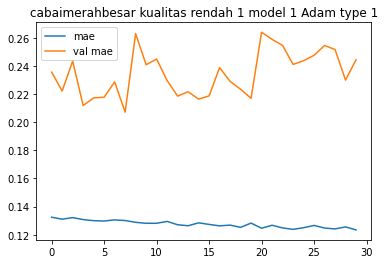

In [ ]:
mae_a1 = history_a1.history['mae']
val_mae_a1 = history_a1.history['val_mae']
epoch_a1 = range(len(mae_a1))

plt.title('cabaimerahbesar kualitas rendah 1 model 1 Adam type 1')
plt.plot(epoch_a1, mae_a1, label='mae')
plt.plot(epoch_a1, val_mae_a1, label='val mae')
plt.legend()
plt.show()

199/199 [==============================] - 1s 4ms/step
6277.2793 15.905621 7251.510739149464


,actual,prediction
0,43400,44216.539062
1,42450,44626.652344
2,40150,44462.074219
3,39600,44729.265625
4,38600,44538.070312
...,...,...
229,41000,46211.789062
230,52950,44767.335938
231,52850,45432.382812
232,40800,44851.500000


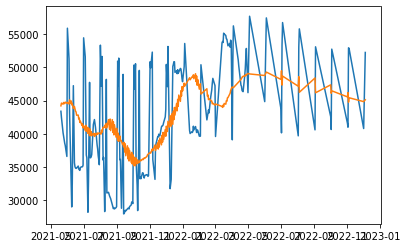

In [ ]:
prediction_a1 = forecast_predict(model_a, test_cabaimerahbesar_, time_size=win_size1, batch_size=5)

data_result_a1 = prediction_a1[(len(x_train))-win_size1:-1, -1 ]
data_result_a1 = scal_range.inverse_transform(data_result_a1.reshape(-1, 1))
data_result_a1 = data_result_a1.reshape(-1)
mae_a1= tf.keras.metrics.mean_absolute_error(x_test, data_result_a1)
mape_a1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result_a1)
mse_a1 = tf.keras.metrics.mean_squared_error(x_test, data_result_a1)

rmse_a1 =math.sqrt(mse_a1.numpy())
print(mae_a1.numpy(), mape_a1.numpy(), rmse_a1)

data_new_cabaimerahbesar_a1 = pd.DataFrame()
data_new_cabaimerahbesar_a1['actual'] = x_test
data_new_cabaimerahbesar_a1['prediction'] = data_result_a1
data_new_cabaimerahbesar_a1.to_csv('cabaimerahbesar_model1_adam_type2.csv')

plt.plot(y_test, data_new_cabaimerahbesar_a1.actual)
plt.plot(y_test, data_new_cabaimerahbesar_a1.prediction)
data_new_cabaimerahbesar_a1

#### Type 3

In [ ]:
history_a2 = model_a.fit(train_step2, epochs=30, validation_data=val_step)

Epoch 1/30
84/84 [==============================] - 1s 16ms/step - loss: 0.0341 - mae: 0.1442 - mape: 674035.3750 - val_loss: 0.0744 - val_mae: 0.2372 - val_mape: 64.4239
Epoch 2/30
84/84 [==============================] - 1s 15ms/step - loss: 0.0338 - mae: 0.1448 - mape: 667442.2500 - val_loss: 0.0748 - val_mae: 0.2375 - val_mape: 64.5240
Epoch 3/30
84/84 [==============================] - 1s 15ms/step - loss: 0.0338 - mae: 0.1435 - mape: 668750.7500 - val_loss: 0.0723 - val_mae: 0.2327 - val_mape: 64.6849
Epoch 4/30
84/84 [==============================] - 1s 16ms/step - loss: 0.0337 - mae: 0.1439 - mape: 677284.8125 - val_loss: 0.0724 - val_mae: 0.2326 - val_mape: 64.7018
Epoch 5/30
84/84 [==============================] - 1s 15ms/step - loss: 0.0337 - mae: 0.1437 - mape: 666574.2500 - val_loss: 0.0717 - val_mae: 0.2304 - val_mape: 64.8884
Epoch 6/30
84/84 [==============================] - 1s 16ms/step - loss: 0.0337 - mae: 0.1438 - mape: 700081.6875 - val_loss: 0.0760 - val_mae: 0

In [ ]:
mae_a2 = history_a2.history['mae']
val_mae_a2 = history_a2.history['val_mae']
epoch_a2 = range(len(mae_a2))

plt.title('cabaimerahbesar kualitas rendah 1 model 1 Adam type 1')
plt.plot(epoch_a2, mae_a2, label='mae')
plt.plot(epoch_a2, val_mae_a2, label='val mae')
plt.legend()
plt.show()

In [ ]:
prediction_a2 = forecast_predict(model_a, test_cabaimerahbesar_, time_size=win_size2, batch_size=5)

data_result_a2 = prediction_a2[(len(x_train))-win_size2:-1, -1 ]
data_result_a2 = scal_range.inverse_transform(data_result_a2.reshape(-1, 1))
data_result_a2 = data_result_a2.reshape(-1)
mae_a2= tf.keras.metrics.mean_absolute_error(x_test, data_result_a2)
mape_a2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result_a2)
mse_a2 = tf.keras.metrics.mean_squared_error(x_test, data_result_a2)

rmse_a2 =math.sqrt(mse_a2.numpy())
print(mae_a2.numpy(), mape_a2.numpy(), rmse_a2)

data_new_cabaimerahbesar_a2 = pd.DataFrame()
# data_new_cabaimerahbesar1['date'] = date_test
data_new_cabaimerahbesar_a2['actual'] = x_test
data_new_cabaimerahbesar_a2['prediction'] = data_result_a2
data_new_cabaimerahbesar_a2.to_csv('cabaimerahbesar_model1_adam_type3.csv')

plt.plot(y_test, data_new_cabaimerahbesar_a2.actual)
plt.plot(y_test, data_new_cabaimerahbesar_a2.prediction)
data_new_cabaimerahbesar_a2

## model 1

### Adam

In [ ]:
model1= Sequential([
    Conv1D(16, kernel_size=5, activation='relu', strides=2, input_shape=[None, 1], padding='causal'),
    LSTM(128, return_sequences=True),
    LSTM(32),
    Dense(64, activation='relu'),
    Dense(128, activation='relu'),
    Dense(1)
])

model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='mse', metrics=['mae', 'mape'])
model1.summary()

#### Type 1

In [ ]:
history1 = model1.fit(train_step, epochs=15, validation_data=val_step)

Epoch 1/15
44/44 [==============================] - 5s 42ms/step - loss: 0.1029 - mae: 0.2562 - mape: 74.3363 - val_loss: 0.1437 - val_mae: 0.3326 - val_mape: 62.0008
Epoch 2/15
44/44 [==============================] - 1s 22ms/step - loss: 0.0389 - mae: 0.1672 - mape: 73.5406 - val_loss: 0.0744 - val_mae: 0.2410 - val_mape: 64.7956
Epoch 3/15
44/44 [==============================] - 1s 22ms/step - loss: 0.0350 - mae: 0.1614 - mape: 73.6166 - val_loss: 0.0772 - val_mae: 0.2466 - val_mape: 64.6102
Epoch 4/15
44/44 [==============================] - 1s 23ms/step - loss: 0.0354 - mae: 0.1618 - mape: 75.3284 - val_loss: 0.0688 - val_mae: 0.2282 - val_mape: 65.2748
Epoch 5/15
44/44 [==============================] - 1s 22ms/step - loss: 0.0345 - mae: 0.1563 - mape: 69.7578 - val_loss: 0.0633 - val_mae: 0.2150 - val_mape: 66.3815
Epoch 6/15
44/44 [==============================] - 1s 22ms/step - loss: 0.0349 - mae: 0.1589 - mape: 74.4114 - val_loss: 0.0703 - val_mae: 0.2316 - val_mape: 65.197

In [ ]:
model1.evaluate(test_step)
mae1 = history1.history['mae']
val_mae1 = history1.history['val_mae']
epoch1 = range(len(mae1))

plt.figure(figsize=(10, 5))
plt.plot(epoch1, mae1, label='mae')
plt.plot(epoch1, val_mae1, label='val mae')
plt.legend()
plt.show()

In [ ]:
prediction1 = forecast_predict(model1, test_cabaimerahbesar_, time_size=win_size, batch_size=5)

data_result1 = prediction1[(len(x_train))-win_size:-1, -1 ]
data_result1 = scal_range.inverse_transform(data_result1.reshape(-1, 1))
data_result1 = data_result1.reshape(-1)
mae1 = tf.keras.metrics.mean_absolute_error(x_test, data_result1)
mape1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1)
mse1 = tf.keras.metrics.mean_squared_error(x_test, data_result1)

rmse1 = math.sqrt(mse1.numpy())
print(mae1.numpy(), mape1.numpy(), rmse1)

data_new_cabaimerahbesar1 = pd.DataFrame()
data_new_cabaimerahbesar1['actual'] = x_test
data_new_cabaimerahbesar1['prediction'] = data_result1
data_new_cabaimerahbesar1.to_csv('cabaimerahbesar_model2_adam_type1.csv')

data_new_cabaimerahbesar1

In [ ]:
plt.figure(figsize=(40, 10))
plt.plot(range(len(x_test)), data_new_cabaimerahbesar1['actual'], '-o')
plt.plot(range(len(x_test)), data_new_cabaimerahbesar1['prediction'], '-o')

#### Type 2

In [ ]:
history1_1 = model1.fit(train_step1, epochs=15, validation_data=val_step)

Epoch 1/15
718/718 [==============================] - 7s 9ms/step - loss: 0.0304 - mae: 0.1366 - mape: 396992.8438 - val_loss: 0.0646 - val_mae: 0.2164 - val_mape: 67.0746
Epoch 2/15
718/718 [==============================] - 7s 9ms/step - loss: 0.0288 - mae: 0.1313 - mape: 339029.4688 - val_loss: 0.0666 - val_mae: 0.2202 - val_mape: 66.4827
Epoch 3/15
718/718 [==============================] - 7s 9ms/step - loss: 0.0285 - mae: 0.1306 - mape: 307960.8125 - val_loss: 0.0662 - val_mae: 0.2197 - val_mape: 66.6561
Epoch 4/15
718/718 [==============================] - 6s 9ms/step - loss: 0.0287 - mae: 0.1323 - mape: 303773.7188 - val_loss: 0.0614 - val_mae: 0.2082 - val_mape: 69.5751
Epoch 5/15
718/718 [==============================] - 7s 9ms/step - loss: 0.0284 - mae: 0.1300 - mape: 384129.3438 - val_loss: 0.0651 - val_mae: 0.2174 - val_mape: 66.3493
Epoch 6/15
718/718 [==============================] - 6s 9ms/step - loss: 0.0279 - mae: 0.1289 - mape: 370361.4062 - val_loss: 0.0735 - val_

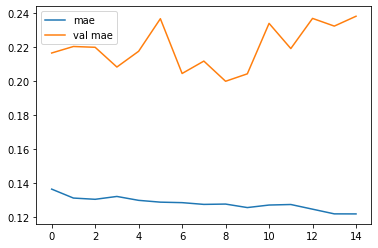

In [ ]:
mae1_1 = history1_1.history['mae']
val_mae1_1 = history1_1.history['val_mae']
epoch1_1 = range(len(mae1_1))

plt.plot(epoch1_1, mae1_1, label='mae')
plt.plot(epoch1_1, val_mae1_1, label='val mae')
plt.legend()
plt.show()

199/199 [==============================] - 1s 4ms/step
6129.459 14.843718 7349.22580956661


,actual,prediction
0,43400,43022.933594
1,42450,42999.687500
2,40150,42194.613281
3,39600,42246.855469
4,38600,41334.660156
...,...,...
229,41000,41628.656250
230,52950,41538.398438
231,52850,41465.367188
232,40800,41560.031250


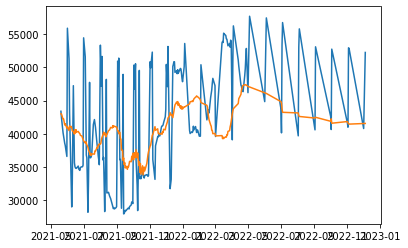

In [ ]:
prediction1_1 = forecast_predict(model1, test_cabaimerahbesar_, time_size=win_size1, batch_size=5)

data_result1_1 = prediction1_1[(len(x_train))-win_size1:-1, -1 ]
data_result1_1 = scal_range.inverse_transform(data_result1_1.reshape(-1, 1))
data_result1_1 = data_result1_1.reshape(-1)
mae1_1 = tf.keras.metrics.mean_absolute_error(x_test, data_result1_1)
mape1_1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1_1)
mse1_1 = tf.keras.metrics.mean_squared_error(x_test, data_result1_1)

rmse1_1 = math.sqrt(mse1.numpy())
print(mae1_1.numpy(), mape1_1.numpy(), rmse1_1)

data_new_cabaimerahbesar1_1 = pd.DataFrame()
data_new_cabaimerahbesar1_1['actual'] = x_test
data_new_cabaimerahbesar1_1['prediction'] = data_result1_1
data_new_cabaimerahbesar1_1.to_csv('cabaimerahbesar_model2_adam_type2.csv')

plt.plot(y_test, data_new_cabaimerahbesar1_1.actual)
plt.plot(y_test, data_new_cabaimerahbesar1_1.prediction)
data_new_cabaimerahbesar1_1

#### Type 3

In [ ]:
history1_2 = model1.fit(train_step2, epochs=15, validation_data=val_step)

In [ ]:
mae1_2 = history1_2.history['mae']
val_mae1_2 = history1_2.history['val_mae']
epoch1_2 = range(len(mae1_2))

plt.plot(epoch1_2, mae1_2, label='mae')
plt.plot(epoch1_2, val_mae1_2, label='val mae')
plt.legend()
plt.show()

In [ ]:
prediction1_2 = forecast_predict(model1, test_cabaimerahbesar_, time_size=win_size2, batch_size=5)

data_result1_2 = prediction1_2[(len(x_train))-win_size2:-1, -1 ]
data_result1_2 = scal_range.inverse_transform(data_result1_2.reshape(-1, 1))
data_result1_2 = data_result1_2.reshape(-1)
mae1_2 = tf.keras.metrics.mean_absolute_error(x_test, data_result1_2)
mape1_2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1_2)
mse1_2 = tf.keras.metrics.mean_squared_error(x_test, data_result1_2)
rmse1_2 = math.sqrt(mse1.numpy())
print(mae1_2.numpy(), mape1_2.numpy(), rmse1_2)

data_new_cabaimerahbesar1_2 = pd.DataFrame()
data_new_cabaimerahbesar1_2['actual'] = x_test
data_new_cabaimerahbesar1_2['prediction'] = data_result1_2
data_new_cabaimerahbesar1_2.to_csv('cabaimerahbesar_model2_adam_type3.csv')

plt.figure(figsize=(10, 5))
plt.plot(y_test, data_new_cabaimerahbesar1_2.actual)
plt.plot(y_test, data_new_cabaimerahbesar1_2.prediction)

data_new_cabaimerahbesar1_2

### SGD

In [15]:
model1_a= Sequential([
    Conv1D(16, kernel_size=5, activation='relu', strides=2, input_shape=[None, 1], padding='causal'),
    LSTM(128, return_sequences=True),
    LSTM(32),
    Dense(64, activation='relu'),
    Dense(128, activation='relu'),
    Dense(1)
])

model1_a.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9), loss='mse', metrics=['mae', 'mape'])
model1_a.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 16)          96        
                                                                 
 lstm (LSTM)                 (None, None, 128)         74240     
                                                                 
 lstm_1 (LSTM)               (None, 32)                20608     
                                                                 
 dense (Dense)               (None, 64)                2112      
                                                                 
 dense_1 (Dense)             (None, 128)               8320      
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 105,505
Trainable params: 105,505
Non-trai

In [ ]:
# plot_model(model1, to_file='model2_plot.png', show_shapes=True, show_layer_names=True)

#### Type1 

In [ ]:
history1_a = model1_a.fit(train_step, epochs=15, validation_data=val_step)

Epoch 1/15
44/44 [==============================] - 5s 48ms/step - loss: 0.1219 - mae: 0.2923 - mape: 90.5386 - val_loss: 0.2968 - val_mae: 0.4925 - val_mape: 87.1705
Epoch 2/15
44/44 [==============================] - 1s 22ms/step - loss: 0.0975 - mae: 0.2469 - mape: 69.1323 - val_loss: 0.2562 - val_mae: 0.4493 - val_mape: 75.2660
Epoch 3/15
44/44 [==============================] - 1s 23ms/step - loss: 0.0796 - mae: 0.2103 - mape: 53.0646 - val_loss: 0.2257 - val_mae: 0.4166 - val_mape: 68.2981
Epoch 4/15
44/44 [==============================] - 1s 31ms/step - loss: 0.0669 - mae: 0.1862 - mape: 46.1901 - val_loss: 0.2010 - val_mae: 0.3918 - val_mape: 65.2428
Epoch 5/15
44/44 [==============================] - 1s 23ms/step - loss: 0.0578 - mae: 0.1728 - mape: 45.8770 - val_loss: 0.1811 - val_mae: 0.3713 - val_mape: 63.3756
Epoch 6/15
44/44 [==============================] - 1s 23ms/step - loss: 0.0513 - mae: 0.1660 - mape: 48.2886 - val_loss: 0.1661 - val_mae: 0.3557 - val_mape: 62.372

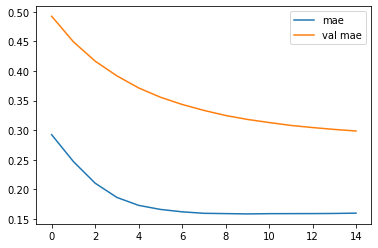

In [ ]:
mae1_a = history1_a.history['mae']
val_mae1_a = history1_a.history['val_mae']
epoch1_a = range(len(mae1_a))

plt.plot(epoch1_a, mae1_a, label='mae')
plt.plot(epoch1_a, val_mae1_a, label='val mae')
plt.legend()
plt.show()

131/131 [==============================] - 2s 8ms/step
7264.223 17.155655 8700.625724624637


,actual,prediction
0,43400,38929.421875
1,42450,38925.832031
2,40150,38929.601562
3,39600,38927.714844
4,38600,38927.277344
...,...,...
229,41000,39102.839844
230,52950,39065.683594
231,52850,39095.390625
232,40800,39069.113281


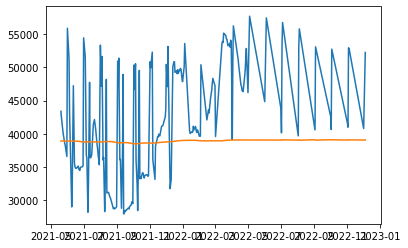

In [ ]:
prediction1_a = forecast_predict(model1_a, test_cabaimerahbesar_, time_size=win_size, batch_size=5)

data_result1_a = prediction1_a[(len(x_train))-win_size:-1, -1 ]
data_result1_a = scal_range.inverse_transform(data_result1_a.reshape(-1, 1))
data_result1_a = data_result1_a.reshape(-1)
mae1_a = tf.keras.metrics.mean_absolute_error(x_test, data_result1_a)
mape1_a = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1_a)
mse1_a = tf.keras.metrics.mean_squared_error(x_test, data_result1_a)

rmse1_a = math.sqrt(mse1_a.numpy())
print(mae1_a.numpy(), mape1_a.numpy(), rmse1_a)

data_new_cabaimerahbesar1_a = pd.DataFrame()
data_new_cabaimerahbesar1_a['actual'] = x_test
data_new_cabaimerahbesar1_a['prediction'] = data_result1_a
data_new_cabaimerahbesar1_a.to_csv('cabaimerahbesar_model2_sgd_type1.csv')


plt.plot(y_test, data_new_cabaimerahbesar1_a.actual)
plt.plot(y_test, data_new_cabaimerahbesar1_a.prediction)

data_new_cabaimerahbesar1_a

#### Type 2


In [ ]:
history1_a1 = model1_a.fit(train_step1, epochs=15, validation_data=val_step)

Epoch 1/15
718/718 [==============================] - 7s 9ms/step - loss: 0.0338 - mae: 0.1460 - mape: 369872.5938 - val_loss: 0.0973 - val_mae: 0.2793 - val_mape: 63.2136
Epoch 2/15
Epoch 2/15
718/718 [==============================] - 7s 10ms/step - loss: 0.0334 - mae: 0.1464 - mape: 408769.9688 - val_loss: 0.0987 - val_mae: 0.2812 - val_mape: 63.1715
Epoch 3/15
Epoch 3/15
718/718 [==============================] - 7s 10ms/step - loss: 0.0334 - mae: 0.1458 - mape: 390502.5625 - val_loss: 0.0977 - val_mae: 0.2799 - val_mape: 63.2276
Epoch 4/15
Epoch 4/15
718/718 [==============================] - 7s 10ms/step - loss: 0.0334 - mae: 0.1458 - mape: 394659.5625 - val_loss: 0.0957 - val_mae: 0.2771 - val_mape: 63.3358
Epoch 5/15
Epoch 5/15
718/718 [==============================] - 7s 10ms/step - loss: 0.0334 - mae: 0.1454 - mape: 463676.0000 - val_loss: 0.0966 - val_mae: 0.2783 - val_mape: 63.3037
Epoch 6/15
Epoch 6/15
718/718 [==============================] - 7s 10ms/step - loss: 0.0332

In [ ]:
mae1_a1 = history1_a1.history['mae']
val_mae1_a1 = history1_a1.history['val_mae']
epoch1_a1 = range(len(mae1_a1))

plt.plot(epoch1_a1, mae1_a1, label='mae')
plt.plot(epoch1_a1, val_mae1_a1, label='val mae')
plt.legend()
plt.show()

In [ ]:
prediction1_a1 = forecast_predict(model1_a, test_cabaimerahbesar_, time_size=win_size1, batch_size=5)

data_result1_a1 = prediction1_a1[(len(x_train))-win_size1:-1, -1 ]
data_result1_a1 = scal_range.inverse_transform(data_result1_a1.reshape(-1, 1))
data_result1_a1 = data_result1_a1.reshape(-1)
mae1_a1 = tf.keras.metrics.mean_absolute_error(x_test, data_result1_a1)
mape1_a1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1_a1)
mse1_a1 = tf.keras.metrics.mean_squared_error(x_test, data_result1_a1)

rmse1_a1 = math.sqrt(mse1_a1.numpy())
print(mae1_a1.numpy(), mape1_a1.numpy(), rmse1_a1)

data_new_cabaimerahbesar1_a1 = pd.DataFrame()
data_new_cabaimerahbesar1_a1['actual'] = x_test
data_new_cabaimerahbesar1_a1['prediction'] = data_result1_a1
data_new_cabaimerahbesar1_a1.to_csv('cabaimerahbesar_model2_sgd_type2.csv')

plt.figure(figsize=(10, 5))
plt.plot(y_test, data_new_cabaimerahbesar1_a1.actual)
plt.plot(y_test, data_new_cabaimerahbesar1_a1.prediction)
data_new_cabaimerahbesar1_a1

#### Type 3

In [16]:
history1_a2 = model1_a.fit(train_step2, epochs=15, validation_data=val_step)

Epoch 1/15
84/84 [==============================] - 18s 51ms/step - loss: 0.1372 - mae: 0.3042 - mape: 16057.1924 - val_loss: 0.2377 - val_mae: 0.4294 - val_mape: 70.7069
Epoch 2/15
84/84 [==============================] - 3s 29ms/step - loss: 0.0843 - mae: 0.2168 - mape: 379759.7188 - val_loss: 0.1721 - val_mae: 0.3620 - val_mape: 62.7155
Epoch 3/15
84/84 [==============================] - 2s 22ms/step - loss: 0.0612 - mae: 0.1857 - mape: 545197.6875 - val_loss: 0.1365 - val_mae: 0.3247 - val_mape: 61.7095
Epoch 4/15
84/84 [==============================] - 1s 16ms/step - loss: 0.0508 - mae: 0.1742 - mape: 646961.7500 - val_loss: 0.1146 - val_mae: 0.3012 - val_mape: 62.4277
Epoch 5/15
84/84 [==============================] - 1s 15ms/step - loss: 0.0462 - mae: 0.1702 - mape: 694288.2500 - val_loss: 0.1024 - val_mae: 0.2862 - val_mape: 62.9651
Epoch 6/15
84/84 [==============================] - 1s 15ms/step - loss: 0.0442 - mae: 0.1687 - mape: 705058.6250 - val_loss: 0.0959 - val_mae: 0

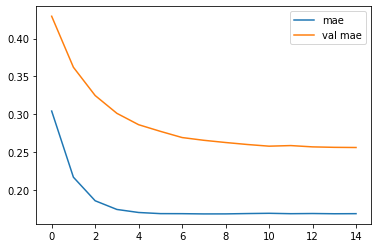

In [17]:
mae1_a2 = history1_a2.history['mae']
val_mae1_a2 = history1_a2.history['val_mae']
epoch1_a2 = range(len(mae1_a2))

plt.plot(epoch1_a2, mae1_a2, label='mae')
plt.plot(epoch1_a2, val_mae1_a2, label='val mae')
plt.legend()
plt.show()

181/181 [==============================] - 1s 5ms/step
6888.737 17.28982 8002.696295624369


,actual,prediction
0,43400,41377.640625
1,42450,41393.972656
2,40150,41398.339844
3,39600,41413.257812
4,38600,41421.335938
...,...,...
229,41000,42504.269531
230,52950,42472.250000
231,52850,42479.441406
232,40800,42440.222656


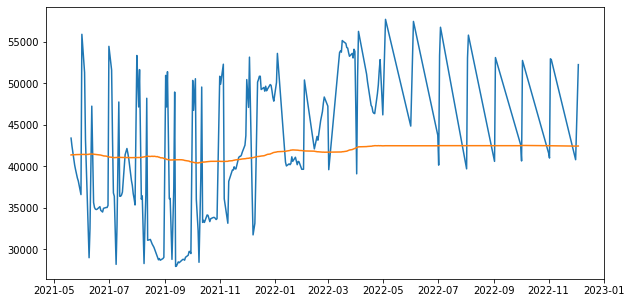

In [18]:
prediction1_a2 = forecast_predict(model1_a, test_cabaimerahbesar_, time_size=win_size2, batch_size=5)

data_result1_a2 = prediction1_a2[(len(x_train))-win_size2:-1, -1 ]
data_result1_a2 = scal_range.inverse_transform(data_result1_a2.reshape(-1, 1))
data_result1_a2 = data_result1_a2.reshape(-1)
mae1_a2 = tf.keras.metrics.mean_absolute_error(x_test, data_result1_a2)
mape1_a2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1_a2)
mse1_a2 = tf.keras.metrics.mean_squared_error(x_test, data_result1_a2)

rmse1_a2 = math.sqrt(mse1_a2.numpy())
print(mae1_a2.numpy(), mape1_a2.numpy(), rmse1_a2)

data_new_cabaimerahbesar1_a2 = pd.DataFrame()
data_new_cabaimerahbesar1_a2['actual'] = x_test
data_new_cabaimerahbesar1_a2['prediction'] = data_result1_a2
data_new_cabaimerahbesar1_a2.to_csv('cabaimerahbesar_model2_sgd_type3.csv')

plt.figure(figsize=(10, 5))
plt.plot(y_test, data_new_cabaimerahbesar1_a2.actual)
plt.plot(y_test, data_new_cabaimerahbesar1_a2.prediction)

data_new_cabaimerahbesar1_a2

## model 2

### SGD

In [ ]:
model2= Sequential([
    Conv1D(8, kernel_size=5, 
                            activation='relu',strides=2,
                            padding='causal', input_shape=[None, 1]),
    tf.keras.layers.MaxPool1D(2, padding="same"),
    LSTM(14, return_sequences=True),
    Dropout(0.3),
    LSTM(64),
    Dense(24, activation='relu'),
    Dense(550, activation='relu'),
    Dense(1)
])

model2.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9), loss='mse', metrics=['mae', 'mape'])
model2.summary()

In [ ]:
# plot_model(model2, to_file='model3_plot.png', show_shapes=True, show_layer_names=True)

#### Type 1

In [ ]:
history2 = model2.fit(train_step, epochs=50, validation_data=val_step)

44/44 [==============================] - 4s 35ms/step - loss: 0.1275 - mae: 0.3014 - mape: 94.5722 - val_loss: 0.3122 - val_mae: 0.5079 - val_mape: 91.4194
Epoch 2/50
Epoch 2/50
44/44 [==============================] - 1s 18ms/step - loss: 0.1024 - mae: 0.2568 - mape: 73.6903 - val_loss: 0.2696 - val_mae: 0.4641 - val_mape: 79.3539
Epoch 3/50
Epoch 3/50
44/44 [==============================] - 1s 16ms/step - loss: 0.0842 - mae: 0.2184 - mape: 55.7640 - val_loss: 0.2368 - val_mae: 0.4284 - val_mape: 70.5342
Epoch 4/50
Epoch 4/50
44/44 [==============================] - 1s 17ms/step - loss: 0.0711 - mae: 0.1936 - mape: 47.8043 - val_loss: 0.2126 - val_mae: 0.4034 - val_mape: 66.4882
Epoch 5/50
Epoch 5/50
44/44 [==============================] - 1s 16ms/step - loss: 0.0618 - mae: 0.1787 - mape: 45.9142 - val_loss: 0.1927 - val_mae: 0.3831 - val_mape: 64.3171
Epoch 6/50
Epoch 6/50
44/44 [==============================] - 1s 16ms/step - loss: 0.0550 - mae: 0.1707 - mape: 47.5971 - val_loss:

In [ ]:
mae2 = history2.history['mae']
val_mae2 = history2.history['val_mae']
loss2 = history2.history['loss']
val_loss2 = history2.history['val_loss']
epoch2 = range(len(mae2))

plt.figure(figsize=(20, 5))
plt.subplot(1,2, 1)
plt.plot(epoch2, mae2, label='mae')
plt.plot(epoch2, val_mae2, label='val mae')
plt.legend()
plt.subplot(1,2,2)
plt.plot(epoch2, loss2, label='loss')
plt.plot(epoch2, val_loss2, label='val loss')
plt.legend()
plt.show()

In [ ]:
prediction2 = forecast_predict(model2, test_cabaimerahbesar_, time_size=win_size, batch_size=5)

data_result2 = prediction2[(len(x_train))-win_size:-1, -1 ]
data_result2 = scal_range.inverse_transform(data_result2.reshape(-1, 1))
data_result2 = data_result2.reshape(-1)
mae2 = tf.keras.metrics.mean_absolute_error(x_test, data_result2)
mape2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2)
mse2 = tf.keras.metrics.mean_squared_error(x_test, data_result2)

rmse2 = math.sqrt(mse2.numpy())
print(mae2.numpy(), mape2.numpy(), rmse2)

data_new_cabaimerahbesar2 = pd.DataFrame()
data_new_cabaimerahbesar2['actual'] = x_test
data_new_cabaimerahbesar2['prediction'] = data_result2
data_new_cabaimerahbesar2.to_csv('cabaimerahbesar_medium_model3_sgd_type1.csv')

plt.figure(figsize=(10, 5))
plt.plot(y_test, data_new_cabaimerahbesar2.actual)
plt.plot(y_test, data_new_cabaimerahbesar2.prediction)
data_new_cabaimerahbesar2

#### Type2

In [ ]:
history2_1 = model2.fit(train_step1, epochs=50, validation_data=val_step)

In [ ]:
mae2_1 = history2_1.history['mae']
val_mae2_1 = history2_1.history['val_mae']
epoch2_1 = range(len(mae2_1))

plt.plot(epoch2_1, mae2_1, label='mae')
plt.plot(epoch2_1, val_mae2_1, label='val mae')
plt.legend()
plt.show()

In [ ]:
prediction2_1 = forecast_predict(model2, test_cabaimerahbesar_, time_size=win_size1, batch_size=5)

data_result2_1 = prediction2_1[(len(x_train))-win_size1:-1, -1 ]
data_result2_1 = scal_range.inverse_transform(data_result2_1.reshape(-1, 1))
data_result2_1 = data_result2_1.reshape(-1)
mae2_1 = tf.keras.metrics.mean_absolute_error(x_test, data_result2_1)
mape2_1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2_1)
mse2_1 = tf.keras.metrics.mean_squared_error(x_test, data_result2_1)

rmse2_1 = math.sqrt(mse2_1.numpy())
print(mae2_1.numpy(), mape2_1.numpy(), rmse2_1)

data_new_cabaimerahbesar2_1 = pd.DataFrame()
data_new_cabaimerahbesar2_1['actual'] = x_test
data_new_cabaimerahbesar2_1['prediction'] = data_result2_1
data_new_cabaimerahbesar2_1.to_csv('cabaimerahbesar_model3_sgd_type2.csv')

data_new_cabaimerahbesar2

#### Type 3

In [ ]:
history2_2 = model2.fit(train_step2, epochs=50, validation_data=val_step)

In [ ]:
mae2_2 = history2_2.history['mae']
val_mae2_2 = history2_2.history['val_mae']
epoch2_2 = range(len(mae2_2))

plt.plot(epoch2_2, mae2_2, label='mae')
plt.plot(epoch2_2, val_mae2_2, label='val mae')
plt.legend()
plt.show()

In [ ]:
prediction2_2 = forecast_predict(model2, test_cabaimerahbesar_, time_size=win_size2, batch_size=5)

data_result2_2 = prediction2_2[(len(x_train))-win_size2:-1, -1 ]
data_result2_2 = scal_range.inverse_transform(data_result2_2.reshape(-1, 1))
data_result2_2 = data_result2_2.reshape(-1)
mae2_2 = tf.keras.metrics.mean_absolute_error(x_test, data_result2_2)
mape2_2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2_2)
mse2_2 = tf.keras.metrics.mean_squared_error(x_test, data_result2_2)

rmse2_2 = math.sqrt(mse2_2.numpy())
print(mae2_2.numpy(), mape2_2.numpy(), rmse2_2)

data_new_cabaimerahbesar2_2 = pd.DataFrame()
data_new_cabaimerahbesar2_2['actual'] = x_test
data_new_cabaimerahbesar2_2['prediction'] = data_result2_2
data_new_cabaimerahbesar2_2.to_csv('cabaimerahbesar_model3_sgd-type3.csv')

data_new_cabaimerahbesar2_2

### Adam

In [ ]:
model2_a= Sequential([
    Conv1D(16, kernel_size=2, 
                            activation='relu',strides=2,
                            padding='causal', input_shape=[None, 1]),
    tf.keras.layers.MaxPool1D(2, padding="same"),
    LSTM(24, return_sequences=True),
    Dropout(0.3),
    LSTM(80),
    Dense(24, activation='relu'),
    Dense(50, activation='relu'),
    Dense(1)
])

model2_a.compile(loss= 'mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), metrics=['mae', 'mape'])
model2_a.summary()

Model: "sequential_5"
Model: "sequential_5"
_________________________________________________________________
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Layer (type)                Output Shape              Param #   
 conv1d_5 (Conv1D)           (None, None, 16)          48        
 conv1d_5 (Conv1D)           (None, None, 16)          48        
                                                                 
                                                                 
 max_pooling1d_1 (MaxPooling  (None, None, 16)         0         
 max_pooling1d_1 (MaxPooling  (None, None, 16)         0         
 1D)                                                             
 1D)                                                             
                                                                 
                                                                 
 lstm_10 (LSTM)              (No

#### type 1

In [ ]:
history2_a = model2_a.fit(train_step, epochs=50, validation_data=val_step)

In [ ]:
mae2_a = history2_a.history['mae']
val_mae2_a = history2_a.history['val_mae']
epoch2_a = range(len(mae2_a))

plt.plot(epoch2_a, mae2_a, label='mae')
plt.plot(epoch2_a, val_mae2_a, label='val mae')
plt.legend()
plt.show()

In [ ]:
prediction2_a = forecast_predict(model2_a, test_cabaimerahbesar_, time_size=win_size, batch_size=5)

data_result2_a = prediction2_a[(len(x_train))-win_size:-1, -1 ]
data_result2_a = scal_range.inverse_transform(data_result2_a.reshape(-1, 1))
data_result2_a = data_result2_a.reshape(-1)
mae2_a = tf.keras.metrics.mean_absolute_error(x_test, data_result2_a)
mape2_a = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2_a)
mse2_a = tf.keras.metrics.mean_squared_error(x_test, data_result2_a)

rmse2_a = math.sqrt(mse2_a.numpy())
print(mae2_a.numpy(), mape2_a.numpy(), rmse2_a)

data_new_cabaimerahbesar2_a = pd.DataFrame()
data_new_cabaimerahbesar2_a['actual'] = x_test
data_new_cabaimerahbesar2_a['prediction'] = data_result2_a
data_new_cabaimerahbesar2_a.to_csv('cabaimerahbesar_model3_adam-type1.csv')

data_new_cabaimerahbesar2_a

#### Type 2

In [ ]:
history2_a1 = model2_a.fit(train_step1, epochs=50, validation_data=val_step)

Epoch 1/50
718/718 [==============================] - 6s 8ms/step - loss: 0.0317 - mae: 0.1430 - mape: 267606.8438 - val_loss: 0.0773 - val_mae: 0.2462 - val_mape: 64.5074
Epoch 2/50
718/718 [==============================] - 6s 8ms/step - loss: 0.0302 - mae: 0.1374 - mape: 291025.6562 - val_loss: 0.0762 - val_mae: 0.2430 - val_mape: 64.5719
Epoch 3/50
718/718 [==============================] - 6s 8ms/step - loss: 0.0301 - mae: 0.1370 - mape: 378659.9688 - val_loss: 0.0724 - val_mae: 0.2342 - val_mape: 64.9634
Epoch 4/50
718/718 [==============================] - 6s 8ms/step - loss: 0.0300 - mae: 0.1368 - mape: 342237.3438 - val_loss: 0.0863 - val_mae: 0.2606 - val_mape: 63.9259
Epoch 5/50
718/718 [==============================] - 6s 8ms/step - loss: 0.0299 - mae: 0.1357 - mape: 308003.3125 - val_loss: 0.0807 - val_mae: 0.2500 - val_mape: 64.2362
Epoch 6/50
718/718 [==============================] - 6s 8ms/step - loss: 0.0299 - mae: 0.1359 - mape: 321121.1250 - val_loss: 0.0647 - val_

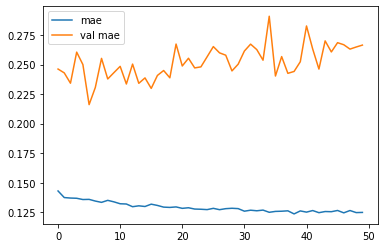

In [ ]:
mae2_a1 = history2_a1.history['mae']
val_mae2_a1 = history2_a1.history['val_mae']
epoch2_a1 = range(len(mae2_a1))

plt.plot(epoch2_a1, mae2_a1, label='mae')
plt.plot(epoch2_a1, val_mae2_a1, label='val mae')
plt.legend()
plt.show()

199/199 [==============================] - 1s 4ms/step
6512.6533 16.586086 7523.072244768091


,actual,prediction
0,43400,43918.847656
1,42450,44353.324219
2,40150,46239.476562
3,39600,44383.203125
4,38600,44573.078125
...,...,...
229,41000,48116.871094
230,52950,44818.250000
231,52850,47385.218750
232,40800,45442.101562


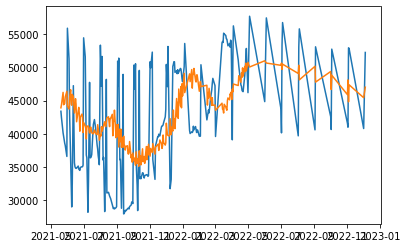

In [ ]:
prediction2_a1 = forecast_predict(model2_a, test_cabaimerahbesar_, time_size=win_size1, batch_size=5)

data_result2_a1 = prediction2_a1[(len(x_train))-win_size1:-1, -1 ]
data_result2_a1 = scal_range.inverse_transform(data_result2_a1.reshape(-1, 1))
data_result2_a1 = data_result2_a1.reshape(-1)
mae2_a1 = tf.keras.metrics.mean_absolute_error(x_test, data_result2_a1)
mape2_a1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2_a1)
mse2_a1 = tf.keras.metrics.mean_squared_error(x_test, data_result2_a1)

rmse2_a1 = math.sqrt(mse2_a1.numpy())
print(mae2_a1.numpy(), mape2_a1.numpy(), rmse2_a1)

data_new_cabaimerahbesar2_a1 = pd.DataFrame()
data_new_cabaimerahbesar2_a1['actual'] = x_test
data_new_cabaimerahbesar2_a1['prediction'] = data_result2_a1
data_new_cabaimerahbesar2_a1.to_csv('cabaimerahbesar_model3_adam-type2.csv')

plt.plot(y_test, data_new_cabaimerahbesar2_a1.actual)
plt.plot(y_test, data_new_cabaimerahbesar2_a1.prediction)
data_new_cabaimerahbesar2_a1

#### Type 3

In [ ]:
history2_a2 = model2_a.fit(train_step2, epochs= 50, validation_data=val_step)

Epoch 1/50
84/84 [==============================] - 1s 14ms/step - loss: 0.0351 - mae: 0.1472 - mape: 611735.0625 - val_loss: 0.0906 - val_mae: 0.2672 - val_mape: 64.1411
Epoch 2/50
84/84 [==============================] - 1s 13ms/step - loss: 0.0343 - mae: 0.1463 - mape: 608410.5000 - val_loss: 0.0893 - val_mae: 0.2642 - val_mape: 64.1991
Epoch 3/50
84/84 [==============================] - 1s 12ms/step - loss: 0.0342 - mae: 0.1447 - mape: 595726.3750 - val_loss: 0.0836 - val_mae: 0.2546 - val_mape: 64.8391
Epoch 4/50
84/84 [==============================] - 1s 13ms/step - loss: 0.0336 - mae: 0.1438 - mape: 563535.8750 - val_loss: 0.0827 - val_mae: 0.2520 - val_mape: 65.0288
Epoch 5/50
84/84 [==============================] - 1s 12ms/step - loss: 0.0339 - mae: 0.1448 - mape: 533515.1875 - val_loss: 0.0856 - val_mae: 0.2583 - val_mape: 64.4968
Epoch 6/50
84/84 [==============================] - 1s 12ms/step - loss: 0.0332 - mae: 0.1421 - mape: 588579.4375 - val_loss: 0.0852 - val_mae: 0

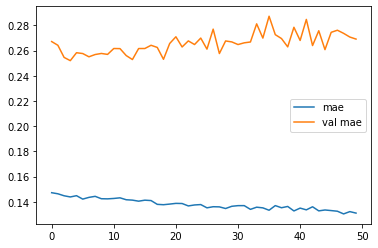

In [ ]:
mae2_a2 = history2_a2.history['mae']
val_mae2_a2 = history2_a2.history['val_mae']
epoch2_a2 = range(len(mae2_a2))

plt.plot(epoch2_a2, mae2_a2, label='mae')
plt.plot(epoch2_a2, val_mae2_a2, label='val mae')
plt.legend()
plt.show()

181/181 [==============================] - 1s 5ms/step
7514.3896 18.207342 8761.1939825574


,actual,prediction
0,43400,47687.679688
1,42450,46498.738281
2,40150,45975.859375
3,39600,45972.265625
4,38600,49400.332031
...,...,...
229,41000,38988.550781
230,52950,39174.328125
231,52850,38962.710938
232,40800,39926.332031


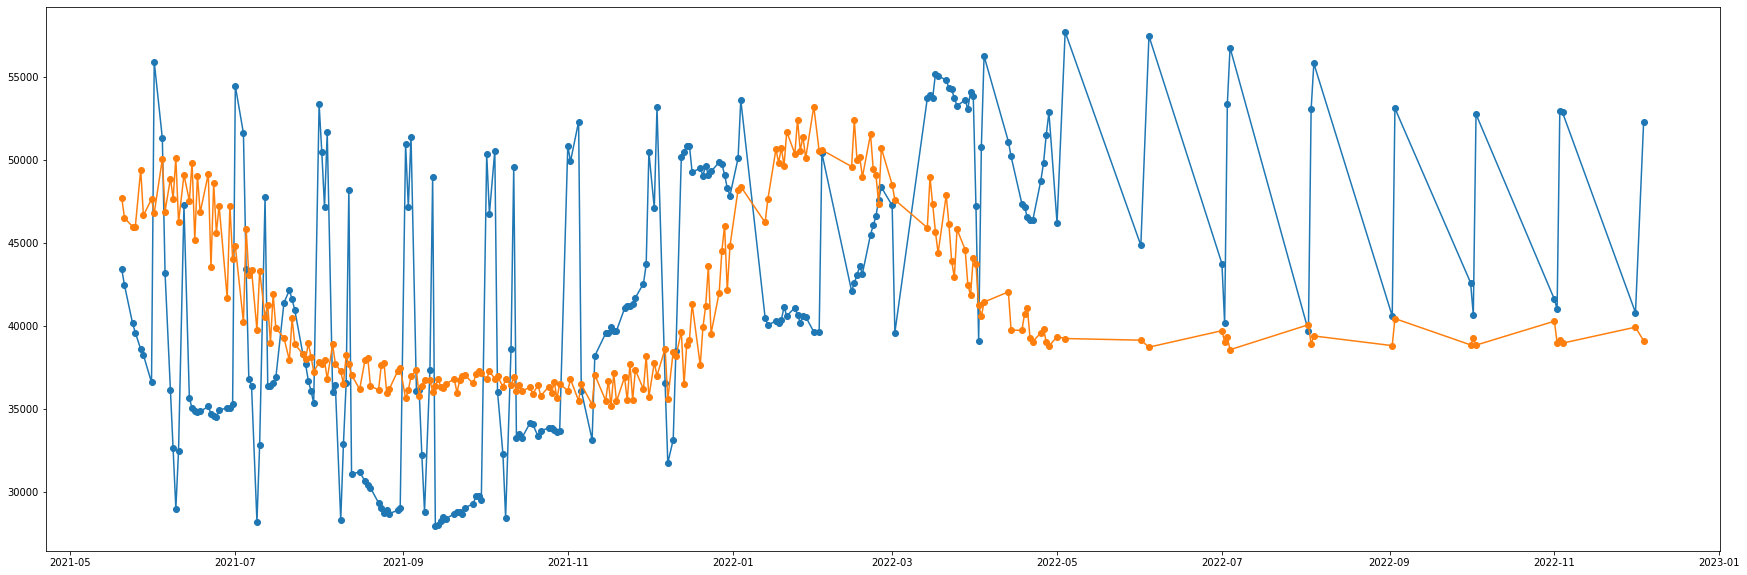

In [ ]:
prediction2_a2 = forecast_predict(model2_a, test_cabaimerahbesar_, time_size=win_size2, batch_size=5)

data_result2_a2 = prediction2_a2[(len(x_train))-win_size2:-1, -1 ]
data_result2_a2 = scal_range.inverse_transform(data_result2_a2.reshape(-1, 1))
data_result2_a2 = data_result2_a2.reshape(-1)
mae2_a2 = tf.keras.metrics.mean_absolute_error(x_test, data_result2_a2)
mape2_a2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2_a2)
mse2_a2 = tf.keras.metrics.mean_squared_error(x_test, data_result2_a2)

rmse2_a2 = math.sqrt(mse2_a2.numpy())
print(mae2_a2.numpy(), mape2_a2.numpy(), rmse2_a2)

data_new_cabaimerahbesar2_a2 = pd.DataFrame()
data_new_cabaimerahbesar2_a2['actual'] = x_test
data_new_cabaimerahbesar2_a2['prediction'] = data_result2_a2
data_new_cabaimerahbesar2_a2.to_csv('cabaimerahbesar_model3_adam_type3.csv')

plt.figure(figsize=(30, 10))
plt.plot(y_test,data_new_cabaimerahbesar2_a2.actual, '-o')
plt.plot(y_test,data_new_cabaimerahbesar2_a2.prediction, '-o')
data_new_cabaimerahbesar2_a2